
# Neural Computing Coursework: MLP vs. SVM
## Ayliah Fani
___
___

## Table of Contents
* [1. Data Import]()
* [2. Exploratory Data Analysis]()
    * [2.1 Emotion Representation]()
    * [2.2 Sentence Length]()
* [3. Feature Engineering]()
    * [3.1 Text Preparation & Cleaning]()
    * [3.2 Encoding]()
    * [3.3 Train-Test Split]()
    * [3.4 Text Representation]()
* [4. Model Building]()
    * [4.1 Multilayer Perceptron]()
        * [4.1.1 ]()
        * [4.1.2 Hyperparameter Tuning & Optimisation]()
        * [4.1.3 Fit & Performance]()
    * [4.2 Support Vector Machine]()
        * [4.2.1 ]()
        * [4.2.2 Hyperparameter Tuning & Optimisation]()
        * [4.2.3 Fit & Performance]()


In [440]:
# import libraries
from pprint import pprint

from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#sns.set_palette("hls")
sns.set_context("notebook")

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import wordnet

import string

import torch
import torch.nn as nn
import torch.functional as F

from sklearn.feature_selection import chi2
from sklearn.experimental import enable_halving_search_cv
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, auc, accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, HalvingRandomSearchCV, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

 ## 1. Data Import
___

In [378]:
# import the data
df_test = pd.read_csv('Data/Emotions/test.txt', sep=',', delimiter=';', header=None, names=['sentence','emotion'])
df_train = pd.read_csv('Data/Emotions/train.txt', sep=',', delimiter=';', header=None, names=['sentence','emotion'])
df_val = pd.read_csv('Data/Emotions/val.txt', sep=',', delimiter=';', header=None, names=['sentence','emotion'])

df = pd.concat([df_test, df_train, df_val])
df = df.reset_index(drop=True)

## 2. Exploratory Data Analysis
___

### 2.1 Number of emotions represented

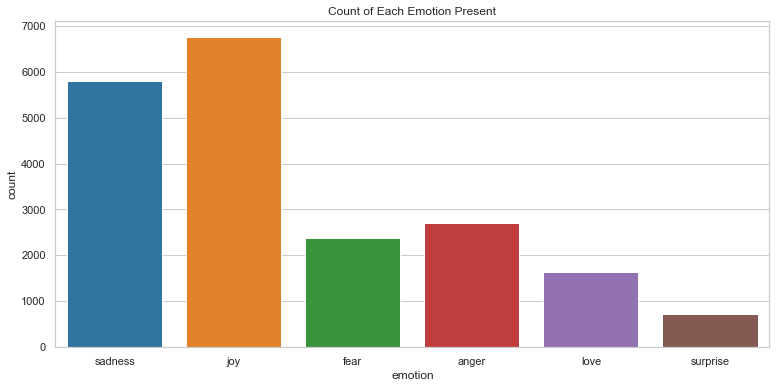

In [379]:
# find the count of each emotion represented.
plt.figure(figsize=(12.8,6))
sns.countplot(x='emotion', data=df).set_title('Count of Each Emotion Present');

From the count plot we can see that this is an imbalanced classification problem.

### 2.2 Sentence Length

/Users/Ayliah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


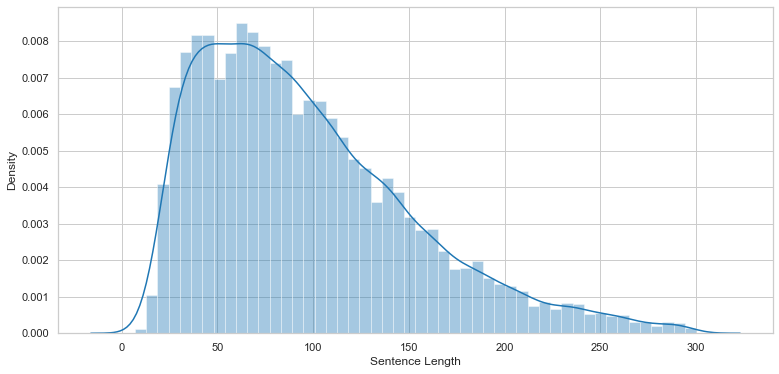

In [380]:
sentence_length = df['sentence'].str.len()
plt.figure(figsize=(12.8,6))
sns.distplot(sentence_length, kde=True, color='#1f77b4')
plt.xlabel('Sentence Length');

most sentences are ~40-70 characters

In [381]:
sentence_length.describe()

count    20000.000000
mean        96.670050
std         55.777923
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: sentence, dtype: float64

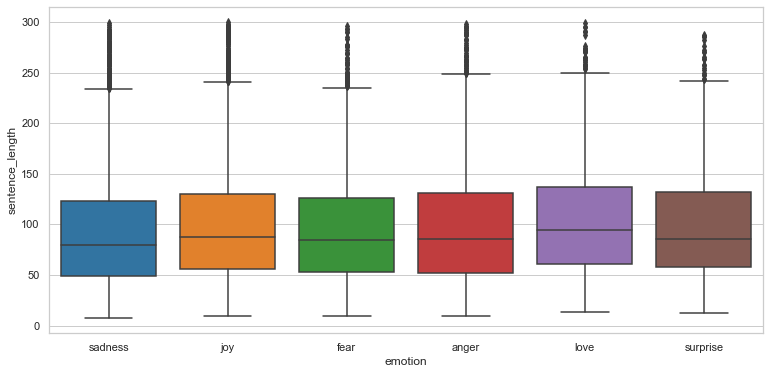

In [382]:
df['sentence_length'] = sentence_length

plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='emotion', y='sentence_length');

sentences of each emotion are generally the same length, so that does not need to be taken into acccount for the classification task


## 3. Feature Engineering
___

### 3.1 Text Prep & Cleaning

In [383]:
stop_words = stopwords.words('english')
stop_words.extend(['im','ive','https','href'])

In [384]:
# method adapted from: https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e


# pos
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.VERB
    

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenise text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in stop_words]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatise text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # there are still some errors after lemmatising 'feeling' so do it again
    text = [WordNetLemmatizer().lemmatize(t, pos='v') for t in text]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["sentence"] = df["sentence"].apply(lambda x: clean_text(x))

### 3.2 Encoding

In [385]:
# replace categories with integer value
emotion_dict = {'sadness':0, 'joy':1, 'fear':2, 'anger':3, 'love':4, 'surprise':5}
df['emotion'] = df['emotion'].map(emotion_dict)

### 3.3 Train-Test Split

In [386]:
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], 
                                                    df['emotion'], 
                                                    test_size=0.2, 
                                                    random_state=0)

### 3.4 Text Representation

In [387]:
# TF-IDF parameters
ngram_range = (1,2)
min_df = 1
max_df = 1.0
max_features = 2000

In [388]:
tfidf = TfidfVectorizer(ngram_range=ngram_range,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test)
labels_test = y_test
print(features_test.shape)

(16000, 2000)
(4000, 2000)


In [389]:
# Find the most prevalent words in each emotion category
for emotion, emotion_id in sorted(emotion_dict.items()):
    features_chi2 = chi2(features_train, labels_train == emotion_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("-- '{}' category:".format(emotion))
    print("  . Most correlated words:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

-- 'anger' category:
  . Most correlated words:
. rude
. dissatisfy
. insult
. greedy
. irritable
  . Most correlated bigrams:
. feel angry
. feel cold

-- 'fear' category:
  . Most correlated words:
. intimidate
. shaky
. anxious
. vulnerable
. terrify
  . Most correlated bigrams:
. feel nervous
. feel anxious

-- 'joy' category:
  . Most correlated words:
. sincere
. talented
. confident
. brave
. content
  . Most correlated bigrams:
. feel well
. feel content

-- 'love' category:
  . Most correlated words:
. delicate
. horny
. tender
. nostalgic
. sympathetic
  . Most correlated bigrams:
. feel sympathetic
. feel love

-- 'sadness' category:
  . Most correlated words:
. ashamed
. melancholy
. punish
. useless
. gloomy
  . Most correlated bigrams:
. feel bad
. feel guilty

-- 'surprise' category:
  . Most correlated words:
. daze
. funny
. amaze
. curious
. impress
  . Most correlated bigrams:
. feel curious
. feel amaze



## 4. Model Building
___

### 4.1 BASE MODEL
use a logistic regression base model to find the best number of features to use, and to compare model performace to the base

In [393]:
# TF-IDF parameters
ngram_range = (1,2)
min_df = 1
max_df = 1.0
max_features = [100, 300, 500, 800, 1000, 2000, 3000, 5000, 7000, 10000]

for i in max_features:
    tfidf = TfidfVectorizer(ngram_range=ngram_range,
                            lowercase=False,
                            max_df=max_df,
                            min_df=min_df,
                            max_features=i,
                            norm='l2',
                            sublinear_tf=True)
    features_train = tfidf.fit_transform(X_train)
    labels_train = y_train
    features_test = tfidf.transform(X_test)
    labels_test = y_test
    # train logistic regression base model at each max_features
    lr_classifier = LogisticRegression(random_state=0, max_iter=1000)
    lr_classifier.fit(features_train, labels_train)
    print("LR score with {} features:".format(i), lr_classifier.score(features_test, labels_test))

LR score with 100 features: 0.374
LR score with 300 features: 0.459
LR score with 500 features: 0.61975
LR score with 800 features: 0.797
LR score with 1000 features: 0.83075
LR score with 2000 features: 0.87
LR score with 3000 features: 0.87625
LR score with 5000 features: 0.8755
LR score with 7000 features: 0.8705
LR score with 10000 features: 0.87


**3000 features** seems to yield the best results, higher values don't add a significant amount of additional accuracy. Since the logistic regression model is able to achieve high accuracy at **87%** so we should aim to have our MLP and SVM models higher

In [394]:
# TF-IDF with the desired max_features found above
ngram_range = (1,2)
min_df = 1
max_df = 1.0
max_features = 3000

tfidf = TfidfVectorizer(ngram_range=ngram_range,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train)
labels_train = y_train

features_test = tfidf.transform(X_test)
labels_test = y_test

### **4.2 SUPPORT VECTOR MACHINE**

#### 4.2.1 Training the Classifier

##### **BASE SVM:**

In [395]:
#Create the SVM model
svc_base = OneVsRestClassifier(SVC(random_state = 0))

#Fit the model for the data
svc_base.fit(features_train, labels_train)

#Make the prediction
y_pred_base = svc_base.predict(features_test)

In [396]:
print('The accuracy of the base SVM is: ', svc_base.score(features_test, labels_test))

The accuracy of the base SVM is:  0.891


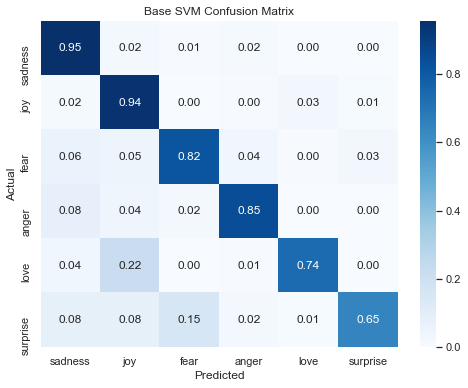

In [417]:
# create confusion matrix
cm = confusion_matrix(labels_test, y_pred_base)

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn, 
            annot=True, 
            fmt='.2f', 
            xticklabels=emotion_dict, 
            yticklabels=emotion_dict, 
            cmap='Blues')
plt.title('Base SVM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [418]:
accuracies = cross_val_score(estimator = svc_base, X = features_train, y = labels_train, cv = 10);
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))

Accuracy: 88.92 %


#### 4.2.2 Hyperparameter Optimisation

SVC hyperparameters to be tuned:
* C, Regularization parameter
* kernel, Specifies the kernel type to be used in the algorithm
* degree, Degree of the polynomial kernel function
* gamma, Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

https://scikit-learn.org/stable/modules/grid_search.html

First we will use RandomSearchCV since the run time is significantly lower than GridSearchCV. Once there is a general idea of what hyperparameters to use GridSearchCV will be used

In [419]:
# find out the hyperparameters currently in use
svc_base.get_params()

{'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': 0,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(random_state=0),
 'n_jobs': None}

**RandomSearchCV:**

In [420]:
## DEFINE THE GRID ###########################################

# C
C = np.linspace(1,100, 30)

# gamma
gamma = [0.001,0.01, 0.1, 1]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True, False]

In [421]:
# SVC random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

# OneVsRest SVC Random Grid
ovrrandom_grid = {'estimator__C': C,
              'estimator__kernel': kernel,
              'estimator__gamma': gamma,
              'estimator__degree': degree,
              'estimator__probability': probability
             }

In [422]:
## RANDOM SEARCH ###########################################

# First create the base model to tune
#svc = SVC(random_state=0)
svc = OneVsRestClassifier(SVC(random_state=0))

# Define the random search
n_iter_search = 30
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=ovrrandom_grid,
                                   n_iter=n_iter_search,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=3, 
                                   random_state=0, 
                                   n_jobs=-1,
                                   refit=True)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=OneVsRestClassifier(estimator=SVC(random_state=0)),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'estimator__C': array([  1.        ,   4.4137931 ,   7.82758621,  11.24137931,
        14.65517241,  18.06896552,  21.48275862,  24.89655172,
        28.31034483,  31.72413793,  35.13793103,  38.55172414,
        41.96551724,  45.37931034,  48.79310345,  52.20689655,
        55.62068966,  59.03448276,  62.44827586,  65.86206897,
        69.27586207,  72.68965517,  76.10344828,  79.51724138,
        82.93103448,  86.34482759,  89.75862069,  93.17241379,
        96.5862069 , 100.        ]),
                                        'estimator__degree': [1, 2, 3, 4, 5, 6],
                                        'estimator__gamma': [0.001, 0.01, 0.1,
                                                             1, 'scale'],
                                        'estimator__kernel': ['linear', 'rbf',
      

In [423]:
print("")
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)


The best hyperparameters from Random Search are:
{'estimator__probability': False, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.01, 'estimator__degree': 6, 'estimator__C': 59.03448275862069}

The mean accuracy of a model with these hyperparameters is:
0.8901875616382379



**GridSearchCV:**

now that we have a general idea of where to look we can narrow it down with grid search

In [431]:
## DEFINE THE GRID ########################################


#C = np.linspace(45,65, 10)
#gamma = [0.001,0.01, 0.1]
#degree = [4,5,6,7]
#probability = [True, False]
#kernel = ['rbf']


C = np.linspace(45,65, 10)
degree = [3, 4, 5]
gamma = [0.001, 0.01, 0.1]
probability = [True, False]

#param_grid = {'estimator__C': C,
#              'estimator__kernel': kernel,
#              'estimator__gamma': gamma,
#              'estimator__degree': degree,
#              'estimator__probability': probability
#             }


param_grid = [
  {'estimator__C': C, 'estimator__kernel':['linear'], 'estimator__probability':probability},
  {'estimator__C': C, 'estimator__kernel':['poly'], 'estimator__gamma':gamma,'estimator__degree':degree, 'estimator__probability':probability},
  {'estimator__C': C, 'estimator__kernel':['rbf'], 'estimator__gamma':gamma, 'estimator__probability':probability}
]


## GRID SEARCH ###########################################

# First create the base model to tune
svc = OneVsRestClassifier(SVC(random_state=0))

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .20, random_state = 0)

# Define the grid search
grid_search = GridSearchCV(estimator=svc,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=cv_sets, 
                                   verbose=3,  
                                   n_jobs=-1,
                                   refit=True)

# Fit the random search model
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 260 candidates, totalling 780 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=None),
             estimator=OneVsRestClassifier(estimator=SVC(random_state=0)),
             n_jobs=-1,
             param_grid=[{'estimator__C': array([45.        , 47.22222222, 49.44444444, 51.66666667, 53.88888889,
       56.11111111, 58.33333333, 60.55555556, 62.77777778, 65.        ]),
                          'estimator__kernel': ['linear'],
                          'estimator__probabili...
                          'estimator__gamma': [0.001, 0.01, 0.1],
                          'estimator__kernel': ['poly'],
                          'estimator__probability': [True, False]},
                         {'estimator__C': array([45.        , 47.22222222, 49.44444444, 51.66666667, 53.88888889,
       56.11111111, 58.33333333, 60.55555556, 62.77777778, 65.        ]),
                          'estimator__gamma': [0.001, 0.01, 0.1],
                          'estimator__kernel': ['rbf'],
            

In [429]:
print("")
print("The best hyperparameters from Random Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)


The best hyperparameters from Random Search are:
{'estimator__C': 50.0, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf', 'estimator__probability': True}

The mean accuracy of a model with these hyperparameters is:
0.8988541666666667


In [432]:
final_svc = grid_search.best_estimator_
final_svc

OneVsRestClassifier(estimator=SVC(C=49.44444444444444, gamma=0.01,
                                  probability=True, random_state=0))

#### 4.2.3 Fit & Performance

In [435]:
final_svc.fit(features_train, labels_train)

OneVsRestClassifier(estimator=SVC(C=49.44444444444444, gamma=0.01,
                                  probability=True, random_state=0))

In [436]:
final_svc_pred = final_svc.predict(features_test)

**Training Accuracy**

In [437]:
# Training accuracy
print("The training accuracy is: ", accuracy_score(labels_train, final_svc.predict(features_train)))

The training accuracy is: 
0.94825


**Test Accuracy**

In [438]:
# Test accuracy
print("The test accuracy is: ", accuracy_score(labels_test, final_svc_pred))

The test accuracy is: 
0.8925


**Classification Report**

In [441]:
# Classification report
print("Classification report")
print(classification_report(labels_test,final_svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1132
           1       0.91      0.92      0.92      1371
           2       0.88      0.84      0.86       490
           3       0.90      0.87      0.89       550
           4       0.81      0.78      0.79       327
           5       0.77      0.68      0.72       130

    accuracy                           0.89      4000
   macro avg       0.86      0.84      0.85      4000
weighted avg       0.89      0.89      0.89      4000



**Confusion Matrix**

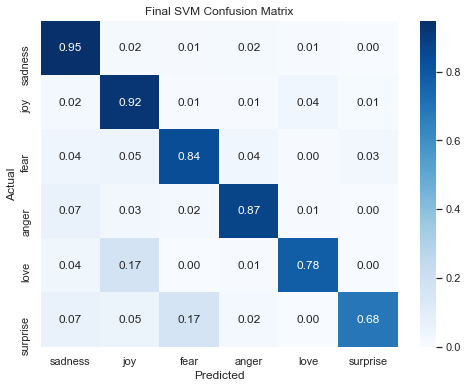

In [442]:
# create confusion matrix
cm_svc_final = confusion_matrix(labels_test, final_svc_pred)

# Normalise
cmn_svc_final = cm_svc_final.astype('float') / cm_svc_final.sum(axis=1)[:, np.newaxis]

# plot
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn_svc_final, 
            annot=True, 
            fmt='.2f', 
            xticklabels=emotion_dict, 
            yticklabels=emotion_dict, 
            cmap='Blues')
plt.title('Final SVM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [457]:
accuracy_score(labels_test, svc_base.predict(features_test))

0.891

In [458]:
accuracy_score(labels_test, final_svc.predict(features_test))

0.8925

In [448]:
y_class = np.argmax(final_svc_pred, axis = 0)

roc_auc_score(labels_test, y_class, multi_class='ovr')

TypeError: Singleton array array(19) cannot be considered a valid collection.

### **4.3 MULTI-LAYER PERCEPTRON**

#### 4.3.1 Training the Classifier
**BASE MLP:**

#### 4.3.2 Hyperparameter Optimisation

#### 4.3.3 Fit & Performance

**===========RANDOM BITS===========**

In [163]:
# Utility function to report best scores from random search
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [294]:
rbf_data = []
lin_data = []
c_optimiser = 70
g_optimiser = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 'auto', 'scale']

headers = ['C Value', 'accuracy', 'gamma']
#for c in c_optimiser:
for g in g_optimiser: 
        #define model
        svc_rbf = SVC(kernel='rbf', C=c, gamma=g)
        #make predictions
        y = svc_rbf.fit(features_train, labels_train).predict(features_test)
        # find AUC
        #fpr, tpr, thresholds = roc_curve(y, labels_test)
        #AUC = auc(fpr, tpr)
        # find accuracy
        accuracy = accuracy_score(y, labels_test)
        values = [c,accuracy,g]
        rbf_data.append(dict(zip(headers,values)))
    
rbf_g=pd.DataFrame(rbf_data)
print(rbf_g.sort_values('accuracy', ascending=False).head(5))



   C Value  accuracy  gamma
2       99  0.826937  0.010
3       99  0.811000  0.100
4       99  0.808937      1
8       99  0.808875  scale
1       99  0.651062  0.001


In [298]:
print(rbf_c.sort_values('accuracy', ascending=False).head(5))
print(rbf_g.sort_values('accuracy', ascending=False).head(5))

   C Value  accuracy  gamma
1        2  0.810312  scale
2        3  0.810063  scale
3        4  0.809562  scale
4        5  0.809063  scale
5        6  0.808937  scale
   C Value  accuracy  gamma
2       99  0.826937  0.010
3       99  0.811000  0.100
4       99  0.808937      1
8       99  0.808875  scale
1       99  0.651062  0.001


In [299]:
rbf_c.sort_values('accuracy', ascending=False)

,C Value,accuracy,gamma
1,2,0.810312,scale
2,3,0.810063,scale
3,4,0.809562,scale
4,5,0.809063,scale
5,6,0.808937,scale
...,...,...,...
34,35,0.808875,scale
33,34,0.808875,scale
32,33,0.808875,scale
31,32,0.808875,scale
